# Pix2Pix

Librerías del ejemplo

In [ ]:
import tensorflow as tf
import os 
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display 

Librerías agregadas

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
import shutil
import random
from random import randint
import cv2

In [ ]:
gpu_available=tf.config.list_physical_devices('GPU')
print(gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Tratamiento de los datos

We locally donwload the dataset of CelebA

In [ ]:
gdd.download_file_from_google_drive(file_id   = 'https://drive.google.com/drive/folders/1NqQiobcVAA8y1vHJrrx-9AVWIEPESG2G?usp=sharing',
                                    dest_path = './datos/img_align_celeba.zip',
                                    unzip     = True,
                                    showsize=True,
                                    overwrite=True)

1.3 GiB Done.
Unzipping...Done.


In [ ]:
DATA_FOLDER   = './datos/img_align_celeba/'
INPUT_DIM     = (128,128,3) #tamaño de la imágen

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
filenames       = np.array(glob(os.path.join(DATA_FOLDER, '*.jpg')))
n_images        = filenames.shape[0]
print ('There are %i files in the database'%n_images)

There are 202599 files in the database


The following function takes the .jpg file, creates an empty template of such dimensions and draws over the original image some random lines of random widths and lengths.

In [ ]:
from copy import deepcopy

In [ ]:
def masking(filepath,folderpath,plot=False):
    #First we read the file to get its measures
    img=cv2.imread(filepath)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    shape=img.shape

    #Measures for each image
    height=shape[0]
    width=shape[1]

    #Create the empty template
    tmp=np.zeros((height,width,3),np.uint8)
    

    #Draw some random lines of random length
    for _ in range(randint(10,15)):
        x1,x2 = randint(1,width), randint(1,width)
        y1,y2 = randint(1,height), randint(1,height)
        thick= randint(1,10) #thickness of lines
        color=(1,1,1) #color of lines, in this case is white
        cv2.line( tmp, (x1,y1), (x2,y2), color ,thick)


    #Masking the given image
    #Change the pixels of the original image with the ones filled in the template
    mask=1-tmp
    masked_img=deepcopy(img)
    masked_img[mask==0]=255


    #We save the masked image and the original one
    images1=np.concatenate( (img,masked_img), axis=1)
    images=cv2.cvtColor(images1, cv2.COLOR_BGR2RGB)
    cv2.imwrite(folderpath+filepath[-10:],images)

    #print('ok')

    # plot the result
    if plot:
      plt.imshow(images1)
      plt.show()

Example

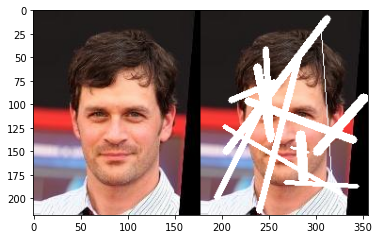

In [ ]:
masking(filenames[2001],'/content/sample_data',True)

Now we masked every celebrity photo of the dataset CelebA.

In [ ]:
for f in filenames:
   masking(f,'/content/dataset/dataset')

As the masked pictures are saved concatenated, we must split them into two independent images. 

First we load the concatenated pictures.

In [ ]:
pictures=np.array(glob(os.path.join('/content/dataset','*.jpg')))

Example

In [ ]:
pictures[0]

'/content/dataset/dataset089070.jpg'

Print the number of pictures we have

In [ ]:
pictures.shape[0]

202599

To work on these pictures we need to tranform them into tensors as follows

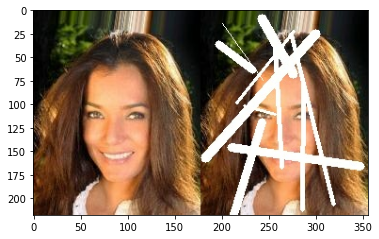

In [ ]:
Im=tf.io.decode_jpeg(tf.io.read_file(pictures[1500]))
plt.imshow(Im)

In [ ]:
Im.shape

TensorShape([218, 356, 3])

Define a function that loads image files and outputs two image tensors:

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Example

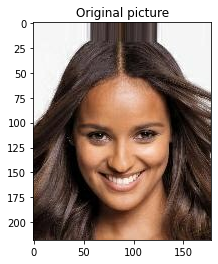

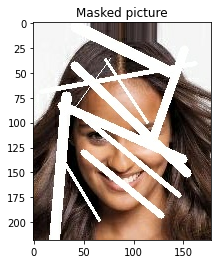

In [ ]:
masked, original = load(pictures[20])
plt.title('Original picture')
plt.imshow(original/255.0)
plt.figure()
plt.title('Masked picture')
plt.imshow(masked/255.0)

In [ ]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

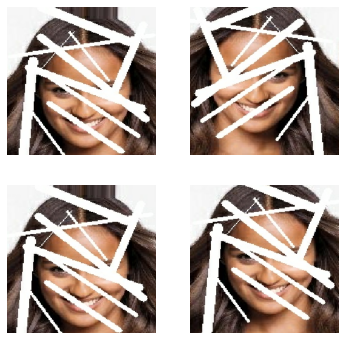

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(masked, original)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

We now load the data for training and testing.

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

Split the datasets into 80% training and 20% test, as usual.

In [ ]:
train_size= int( 0.8* n_images)
test_size= n_images-train_size

In [ ]:
n_images

202599

In [ ]:
train_dataset = tf.data.Dataset.list_files(pictures[:train_size])
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
try:
  test_dataset = tf.data.Dataset.list_files(pictures[train_size:])
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(pictures[train_size:])
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Build generator

In [ ]:
OUTPUT_CHANNELS = 3

Encoder 

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Decoder

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()

Valor de la penalización $\lambda$

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

# Build Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

# Model (Optimization)

Define de optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir='/content'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Define the function that generates images during training

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

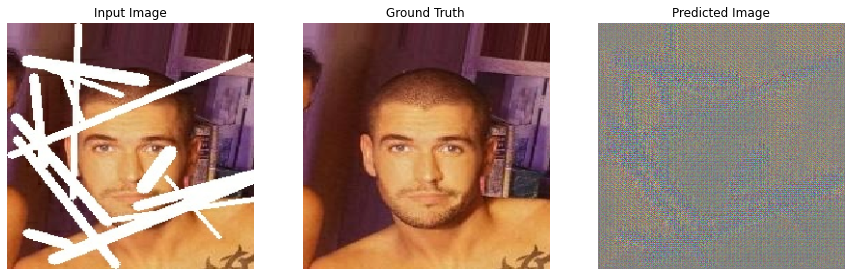

In [ ]:
for pic in test_dataset.take(1):
  example_input=np.expand_dims(pic[0][0], axis=0)
  example_target=np.expand_dims(pic[1][0], axis=0)
  generate_images(generator, example_input, example_target)
  break

Training

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 168.42 sec



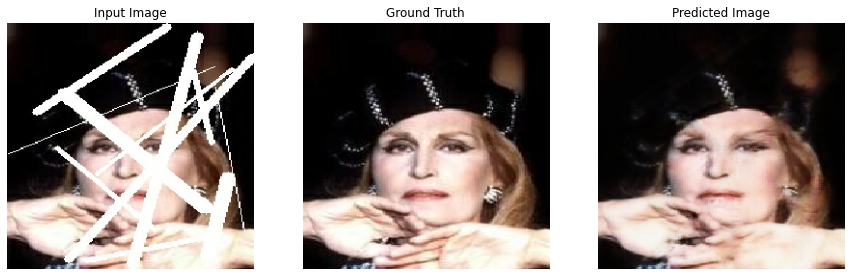

Step: 49k
....................................................................................................

In [ ]:
fit(train_dataset,test_dataset,steps=50000)

Restore the latest checkpoint and test the network.

In [ ]:
ls {checkpoint_dir}

checkpoint                   ckpt-5.index
ckpt-10.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-10.index                ckpt-6.index
ckpt-11.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-11.index                ckpt-7.index
ckpt-12.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-12.index                ckpt-8.index
ckpt-1.data-00000-of-00001   ckpt-9.data-00000-of-00001
ckpt-1.index                 ckpt-9.index
ckpt-2.data-00000-of-00001   dataset/
ckpt-2.index                 datos/
ckpt-3.data-00000-of-00001   logs/
ckpt-3.index                 sample_data/
ckpt-4.data-00000-of-00001   sample_data125224.jpg
ckpt-4.index                 sample_data196556.jpg
ckpt-5.data-00000-of-00001   untitled


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

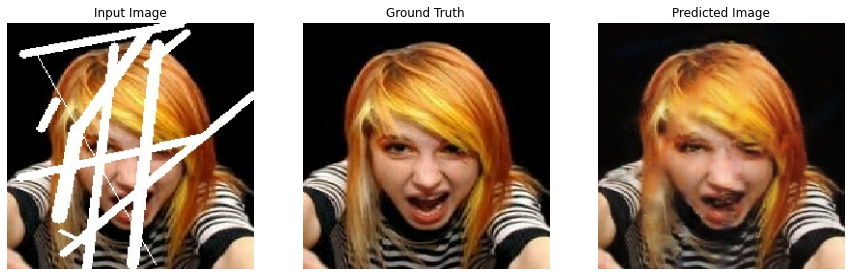

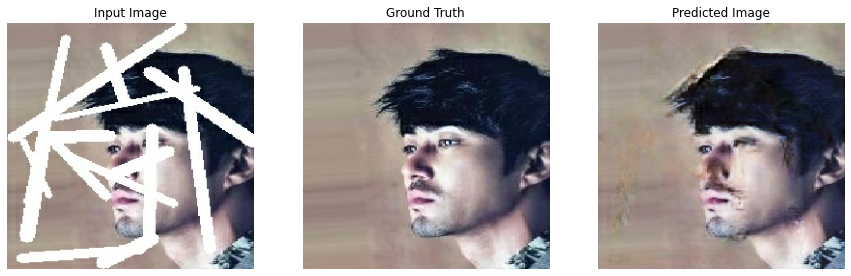

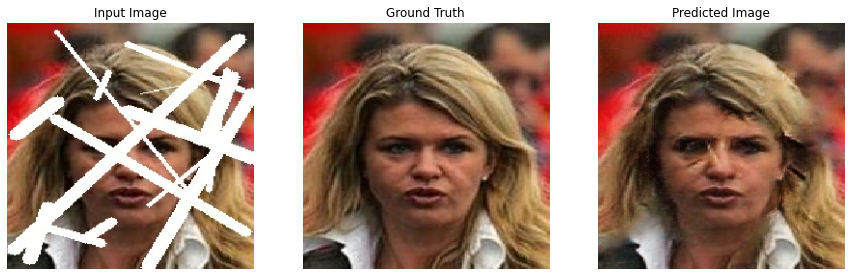

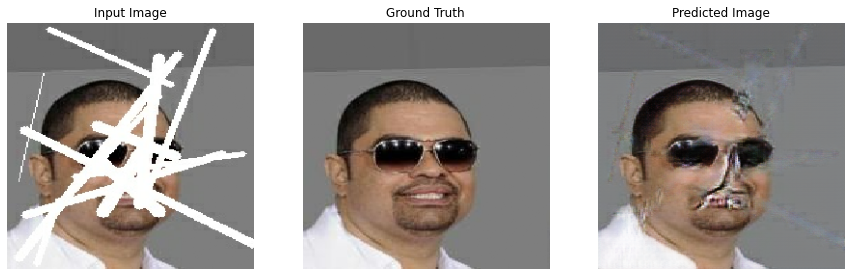

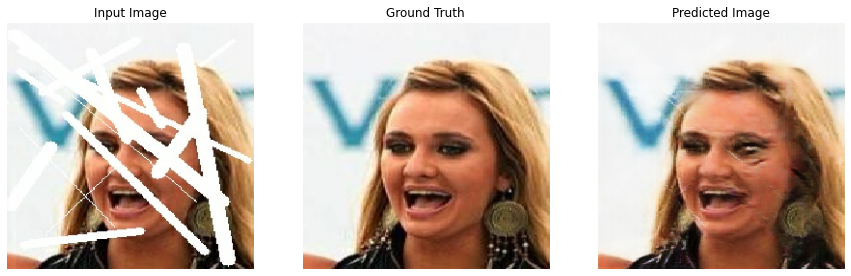

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

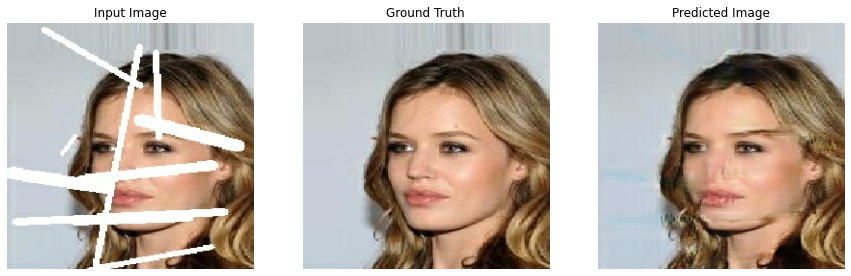

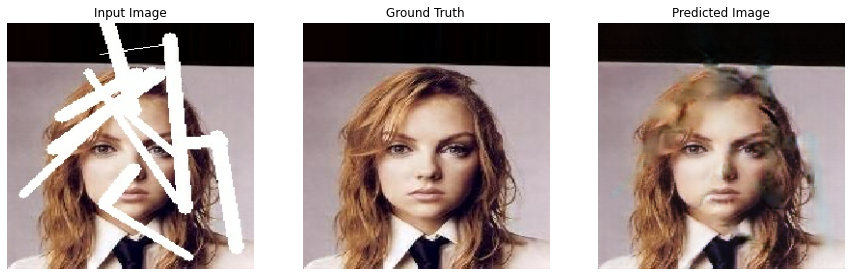

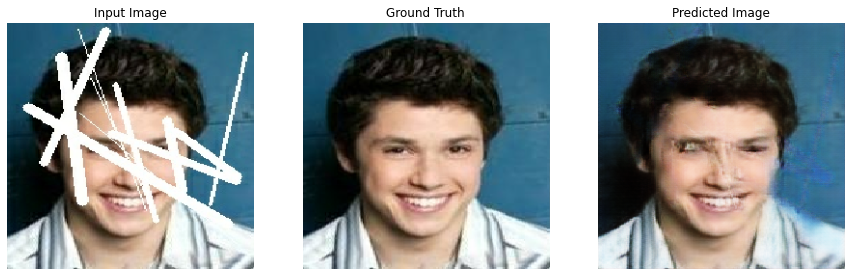

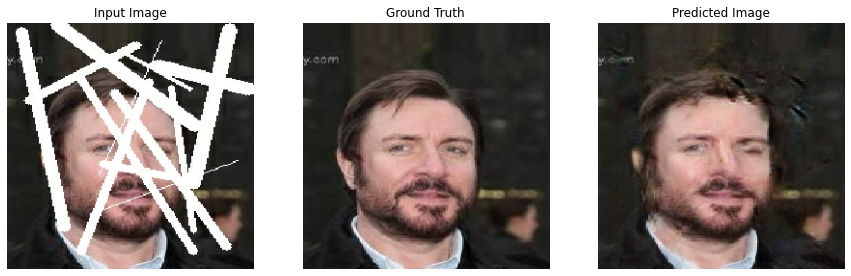

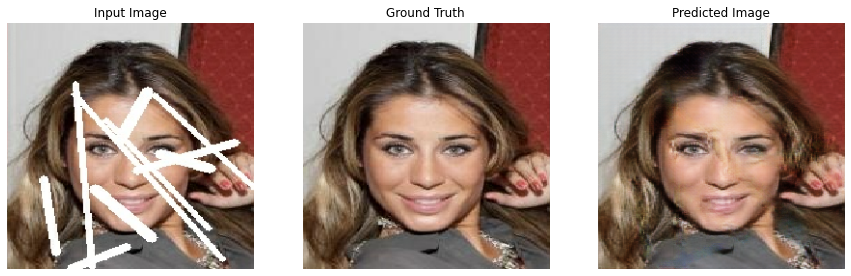

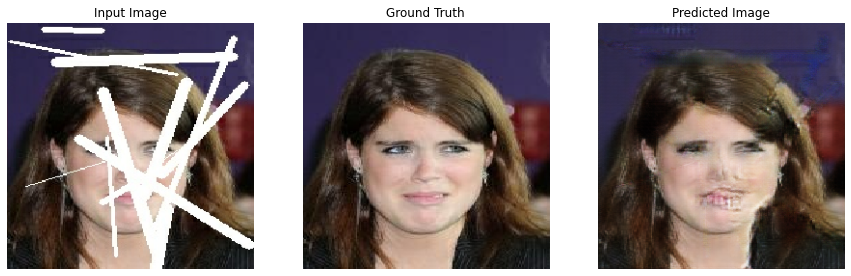

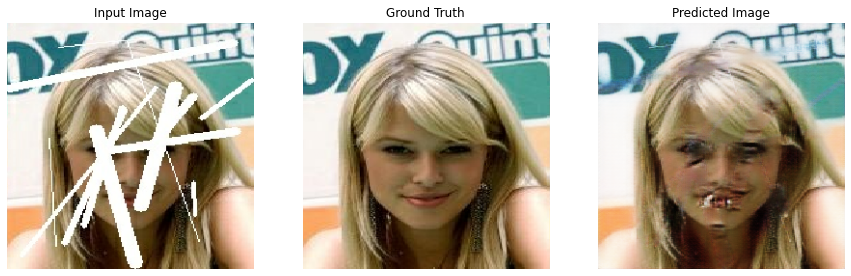

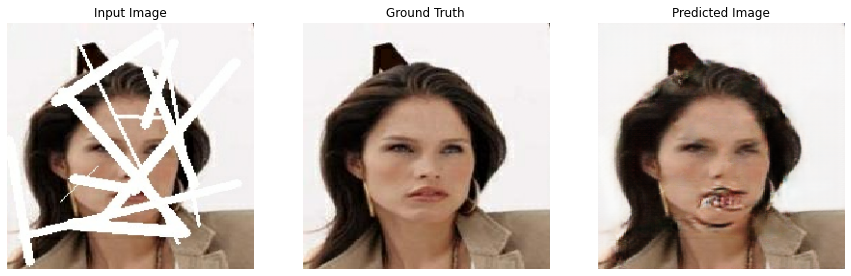

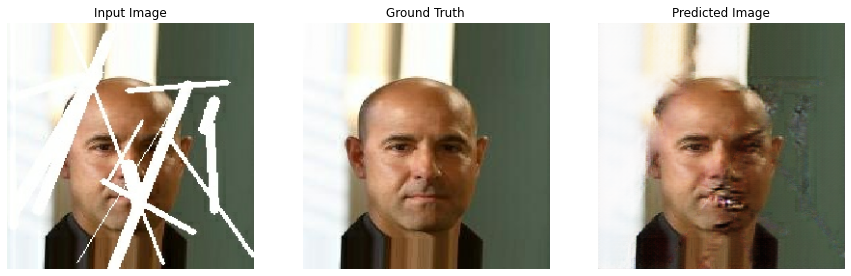

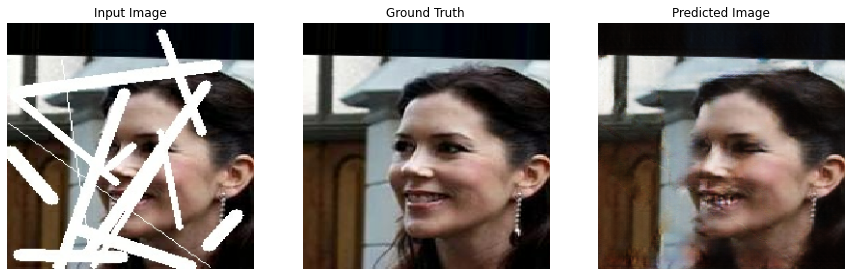

In [ ]:
for inp, tar in test_dataset.take(10):
  generate_images(generator, inp, tar)

# Conclusions

As we notice depending on the location of the lines, the networks predict the picture blurry if the lines cover most of the picture as seen in the last picture. On the other hand if the lines leave most of face uncovered as in the first and second one, the predicted pictures is much better.